In [1]:
import sys
sys.path.append('..')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".30"
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path
import flowrec.training_and_states as state_utils
import flowrec.losses as losses
import utils.simulation2d as project
import flowrec.data as data_utils

import jax
import optax
import haiku as hk
import wandb

In [ ]:
a = {'a':1,'c':2}
if 'c' in a:
    print(a['a'])

In [3]:
train_test_split = [600,100,100]
learning_rate = 0.0001
mlp_layers = [] # size of the intermediate layers
cnn_channels = [32,16,2]
cnn_filter = [(3,3)]
dropout_rate = 0.02
regularisation_strength = 0.0001
epochs = 20000
nb_batches = 6
data_dir = Path("./local_data/re200")

In [4]:
x_base = 132
(ux,uy,pp) = project.read_data(data_dir,x_base)
x = np.stack([ux,uy,pp],axis=0)

data_randseed = np.random.randint(1,1000000)
[x_train,x_val,x_test], [xm_train,xm_val,xm_test] = data_utils.data_partition(x,1,train_test_split,REMOVE_MEAN=True,randseed=data_randseed,SHUFFLE=True)

[ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
[ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
[ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))


triangle_base_coords = [49,80]
pb_train = project.take_measurement_base(pp_train,ly=triangle_base_coords,centrex=0)
pb_val = project.take_measurement_base(pp_val,ly=triangle_base_coords,centrex=0)
pb_test = project.take_measurement_base(pp_test,ly=triangle_base_coords,centrex=0)

u_train = np.stack((ux_train,uy_train),axis=-1)
u_val = np.stack((ux_val,uy_val),axis=-1)
u_test = np.stack((ux_test,uy_test),axis=-1)


(nt,nx,ny) = ux_train.shape
n_base = pb_train.shape[-1]

mlp_layers.extend([2*nx*ny])

In [5]:
from flowrec.models.cnn import Model

# =================== model ===============
rng = jax.random.PRNGKey(np.random.randint(10,50))
optimizer = optax.adamw(learning_rate=learning_rate,weight_decay=regularisation_strength)
mdl = Model(mlp_layers,output_shape=(nx,ny,2),cnn_channels=cnn_channels,cnn_filters=cnn_filter,dropout_rate=dropout_rate)

Freeze the first layer

In [6]:
from flowrec.training_and_states import TrainingState
params = mdl.init(rng,pb_train[0,:]) # initalise weights

In [7]:
jax.tree_util.tree_map(lambda x: print(x.shape),params)

(32,)
(3, 3, 2, 32)
(16,)
(3, 3, 32, 16)
(2,)
(3, 3, 16, 2)
(98298,)
(31, 98298)


{'mlp_with_cnn/~/convolve_0': {'b': None, 'w': None},
 'mlp_with_cnn/~/convolve_1': {'b': None, 'w': None},
 'mlp_with_cnn/~/convolve_2': {'b': None, 'w': None},
 'mlp_with_cnn/~/mlp/~/linear_0': {'b': None, 'w': None}}

Split weights and test

In [ ]:
## load a previously trained fully connected layer
trained_state = state_utils.restore_trainingstate(Path(),'state')

In [8]:
trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda layer, name, values: layer != "mlp_with_cnn/~/mlp/~/linear_0",params
)

opt_state = optimizer.init(trainable_params)
state = TrainingState(trainable_params, opt_state)

In [9]:
print(list(trainable_params))
print(list(non_trainable_params))

['mlp_with_cnn/~/convolve_0', 'mlp_with_cnn/~/convolve_1', 'mlp_with_cnn/~/convolve_2']
['mlp_with_cnn/~/mlp/~/linear_0']


In [11]:
linear_w = non_trainable_params["mlp_with_cnn/~/mlp/~/linear_0"]['w']
# linear_w = jax.numpy.ones_like(non_trainable_params["mlp_with_cnn/~/mlp/~/linear_0"]['w'])
linear_b = non_trainable_params["mlp_with_cnn/~/mlp/~/linear_0"]['b']

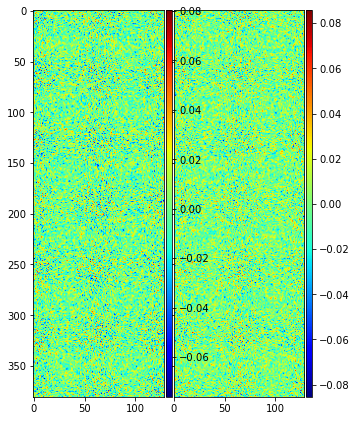

In [12]:
intermediate_results = pb_train[0,:]@linear_w + linear_b
intermediate_results = intermediate_results.reshape((1,nx,ny,2))

fig = plt.figure(figsize=(5,10))
grid = ImageGrid(fig,111,(1,2),share_all=True,cbar_mode="each")
for ax,v,cax in zip(grid,[0,1],grid.cbar_axes):
    im = ax.imshow(intermediate_results[0,...,v],'jet')
    plt.colorbar(im,cax=cax)

In [16]:
@jax.jit
def loss(trainable, rng, x, y, non_trainable):
# def loss(trainable, rng, x, y):
    params = hk.data_structures.merge(trainable,non_trainable)
    pred = mdl.apply(params,rng,x)
    # pred = mdl.apply(trainable,rng,x)
    l = losses.mse(pred,y)
    return l

@jax.jit
def validation_loss(trainable, x, y, non_trainable):
    params = hk.data_structures.merge(trainable,non_trainable)
    pred = mdl.predict(params,x)
    l = losses.mse(pred,y)
    return l

@jax.jit
def update(state,rng,x,y):
    l,trainable_grads = jax.value_and_grad(loss)(state.params,rng,x,y,non_trainable_params)
    updates,opt_state = optimizer.update(trainable_grads,state.opt_state,state.params)
    trainable_params = optax.apply_updates(state.params,updates)
    state = TrainingState(trainable_params,opt_state)
    return l,state

In [14]:
loss_train = []
loss_val = []
wandb_config = {
    "learning_rate": learning_rate,
    "layers": mlp_layers,
    "number_of_layers": len(mlp_layers)+len(cnn_channels),
    "cnn_filter": cnn_filter,
    "activation": "tanh",
    "loss_fn": "mse",
    "dropout_rate":dropout_rate,
    "l2_strength":regularisation_strength,
    "Re": 200
}
run = wandb.init(config=wandb_config,project="FlowReconstruction",group='FF_CNN',tags=["random_mlp","freeze_layer"])

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yaxinm. Use `wandb login --relogin` to force relogin


In [17]:
for i in range(50000):
    [rng] = jax.random.split(rng,1)
    xx_batched = jax.numpy.array_split(pb_train,6,axis=0)
    yy_batched = jax.numpy.array_split(u_train,6,axis=0) # slow
    loss_epoch = []
    for b in range(6):
        l,state = update(state,rng,xx_batched[b],yy_batched[b])        
        if dropout_rate is None:
            loss_epoch.append(l)
        else:
            l = validation_loss(state.params,xx_batched[b],yy_batched[b],non_trainable_params)
            loss_epoch.append(l)
    loss_train.append(np.mean(loss_epoch))

    l_val = validation_loss(state.params,pb_val,u_val,non_trainable_params)
    loss_val.append(l_val)        
    
    run.log({'loss':l,'loss_val':l_val})

    if i%500==0:
        print(i,l)
run.finish()

0 0.19644213
500 0.19630465
1000 0.1962955
1500 0.19629239
2000 0.19629055
2500 0.19628948
3000 0.1962888
3500 0.19628839
4000 0.19628815
4500 0.19628789
5000 0.19628769
5500 0.19628772
6000 0.19628735
6500 0.19628726
7000 0.1962871
7500 0.19628704
8000 0.1962869
8500 0.19628692
9000 0.19628683
9500 0.19628686
10000 0.19628683
10500 0.19628642
11000 0.19628662


ValueError: setting an array element with a sequence.

In [18]:
run.finish()

loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.19629
loss_val,0.19545


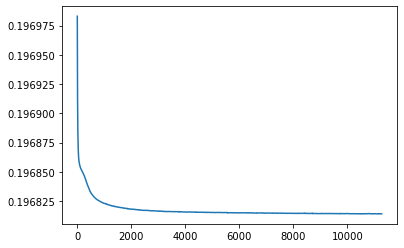

In [19]:
plt.figure()
plt.plot(loss_train)
# plt.xlim([4500,5000])
plt.show()

In [20]:
params = hk.data_structures.merge(state.params,non_trainable_params)

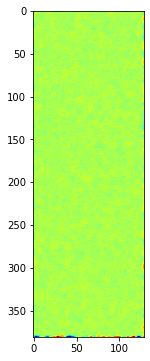

In [22]:
out = mdl.apply(params,rng,pb_train[3,:])
fig = plt.figure(figsize=(3,6))
plt.imshow(out[0,:,:,0],'jet')
plt.show()